In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pysindy as ps

## Numerical solutions

In [2]:
omega = 1.00

def SHO (t, y):
    x, v = y
    dxdt = v 
    dvdt = -omega**2 * x 
    return [dxdt, dvdt]

y0 = [1.0 , 1.0]
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

solution_sho = solve_ivp (SHO, t_span, y0, t_eval=t_eval)

In [3]:
# solve diffusion pde

numx = 101
numt = 2001
Lx = 1.0
Tf = 0.1
dx = Lx / (numx-1)
dt = Tf / (numt-1)

x = np.arange(0, Lx + dx, dx)
t = np.arange(0, Tf + dt, dt)

phi = np.zeros((numx, numt))

mu = 0.5
sigma = 0.05
phi[:, 0] = np.exp( -(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

In [4]:
for j in np.arange(0, numt-1): 
    for i in np.arange(1, numx-1): 
        phi[i, j+1] = phi[i, j] + (dt/dx**2) * (phi[i+1, j] - 2*phi[i, j] + phi[i-1, j])
    phi[0, j+1] = phi[1, j+1]    
    phi[numx-1, j+1] = phi[numx-2, j+1]

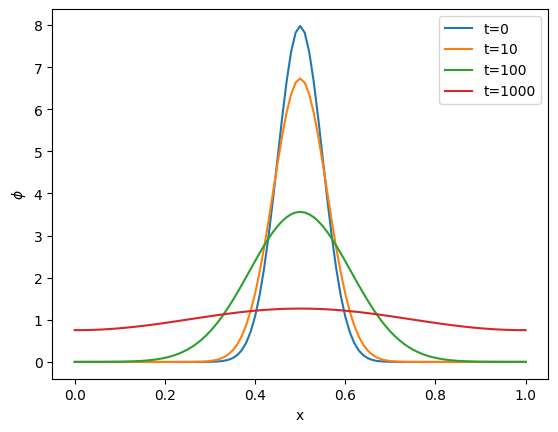

In [5]:
plt.plot(x , phi[:,0], label='t=0')
plt.plot(x, phi[:, 10], label='t=10')
plt.plot(x, phi[:, 100], label='t=100')
plt.plot(x, phi[:, 1000], label='t=1000')
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.legend()
plt.show()

In [6]:
print(f'$\phi$ shape={phi.shape}')
print(f'x shape={x.shape}')
print(f't shape={t.shape}')

$\phi$ shape=(101, 2001)
x shape=(101,)
t shape=(2001,)


In [7]:
phi_dot = ps.FiniteDifference(axis=1)._differentiate(phi, t=dt)

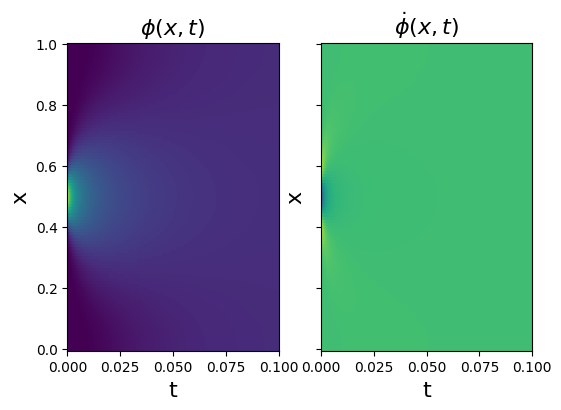

In [9]:
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot phi and phi_dot
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, phi)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\phi(x, t)$', fontsize=16)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, phi_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{\phi}(x, t)$', fontsize=16)
plt.show()

In [8]:
phi_ps = phi[:,:,np.newaxis]
print(phi_ps.shape)

(101, 2001, 1)


## Clean diffusion + SINDy

In [9]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
for thr in [0.1, 0.2, 0.5, 0.7]:
    optimizer = ps.STLSQ(threshold=thr, 
                         alpha=1e-5, 
                        )#normalize_columns=True)
    model = ps.SINDy(feature_library=pde_lib, 
                    optimizer=optimizer,
                    feature_names=['u'])
    model.fit(phi_ps, t=dt)
    model.print(lhs=['du/dt'])
    

STLSQ model: 
du/dt = -0.310 u + 0.332 u^2 + 1.021 u_11
du/dt = -0.310 u + 0.332 u^2 + 1.021 u_11
du/dt = 1.016 u_11
du/dt = 1.016 u_11


In [34]:

pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=1e-5, )#normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=1,
    max_iter=1000,
    tol=1e-15,
    nu=10,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=1, 
    max_iter=1000, 
    tol=1e-15, 
    thresholder="l1", 
    normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SSR model: ')
optimizer = ps.SSR(kappa=1e-2,
                   normalize_columns=True, 
                   max_iter=100,
                    alpha=.6,
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   normalize_columns=True, 
                   kappa=1e-8)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

print('FROLs model: ')
optimizer = ps.FROLS(kappa=1e-8,
                     ) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['u'])
model.fit(phi_ps, t=dt)
model.print(lhs=['du/dt'])

STLSQ model: 
du/dt = 1.016 u_11
SR3 model, L0 norm: 
du/dt = -1.186 u + 1.035 u^2 + 1.000 u_11 + 0.013 uu_11 + -0.001 u^2u_11
SR3 model, L1 norm: 
du/dt = -1.124 u + 0.985 u^2 + 1.001 u_11 + 0.012 uu_11 + -0.001 u^2u_11
SSR model: 
du/dt = 1.008 u_11 + 0.001 uu_11
SSR (metric = model residual) model: 
du/dt = 1.016 u_11
FROLs model: 
du/dt = 1.016 u_11


## Noisy diffusion + normal SINDy

In [35]:
eta_list = np.array([0., 0.01, 0.02, 0.05, 0.1])

phi_noisy = np.array([phi_ps + eta * np.random.random(phi_ps.shape) for eta in eta_list])

phi_noisy_dot = np.array([ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt) for i in range(phi_noisy.shape[0])])

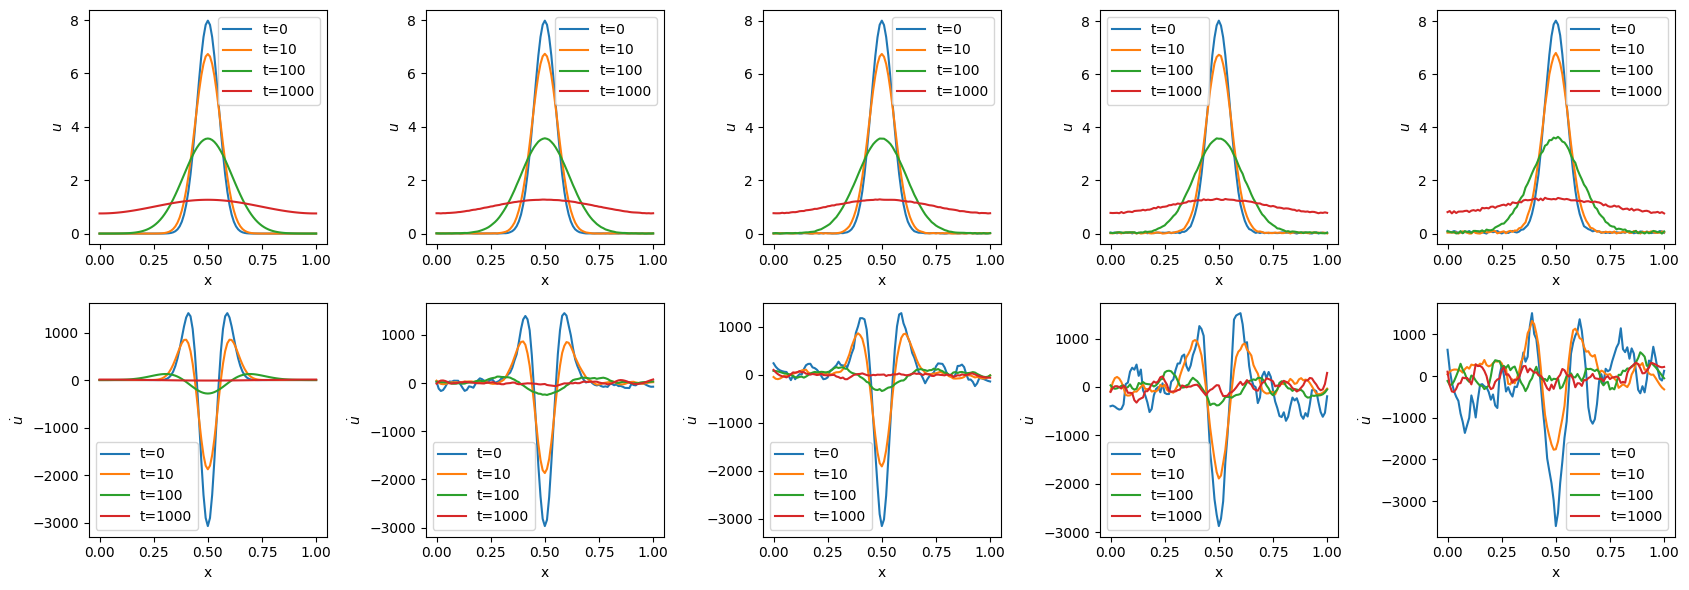

In [36]:
fig, axs = plt.subplots(2,len(eta_list), figsize = (17,6))
for i in range(len(eta_list)): 
    axs[0, i].plot(x , phi_noisy[i, :,0], label='t=0')
    axs[0, i].plot(x, phi_noisy[i, :, 10], label='t=10')
    axs[0, i].plot(x, phi_noisy[i, :, 100], label='t=100')
    axs[0, i].plot(x, phi_noisy[i, :, 1000], label='t=1000')
    axs[0, i].set_xlabel('x')
    axs[0, i].set_ylabel('$u$')
    axs[0, i].legend()
    
for i in range(len(eta_list)): 
    axs[1, i].plot(x , phi_noisy_dot[i, :,0], label='t=0')
    axs[1, i].plot(x, phi_noisy_dot[i, :, 10], label='t=10')
    axs[1, i].plot(x, phi_noisy_dot[i, :, 100], label='t=100')
    axs[1, i].plot(x, phi_noisy_dot[i, :, 1000], label='t=1000')
    axs[1, i].set_xlabel('x')
    axs[1, i].set_ylabel('$\dot{u}$')
    axs[1, i].legend()

fig.tight_layout()
fig.show()

### Using PDELibrary

In [43]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)


print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=1e-5, )#normalize_columns=True)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t']
                     #differentiation_method=ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-5)
                     )
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print(lhs = ['du/dt'])

STLSQ model: 
du/dt = 1.016 u_11
du/dt = 51.580 u + -39.797 u^2
du/dt = 51.840 u + -39.853 u^2
du/dt = 51.957 u + -39.563 u^2
du/dt = 53.025 u + -39.766 u^2


In [44]:

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=1,
    max_iter=1000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    #normalize_columns=True,
)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print(lhs = ['du/dt'])
    


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=1, max_iter=1000, tol=1e-15, 
    thresholder="l1", normalize_columns=True
)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print(lhs = ['du/dt'])
 
 
    
print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   #normalize_columns=True, 
                   kappa=1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs = ['du/dt'])
    
    
print('FROLs model: ')
optimizer = ps.FROLS(kappa=1e-5, normalize_columns=True)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer, 
                     feature_names=['u','x','t'])
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs = ['du/dt'])

SR3 model, L0 norm: 
du/dt = -1.186 u + 1.035 u^2 + 1.000 u_11
du/dt = 16.104 u + -12.136 u^2
du/dt = 25.924 u + -20.169 u^2
du/dt = 34.713 u + -26.964 u^2
du/dt = 40.243 u + -30.717 u^2
SR3 model, L1 norm: 
du/dt = -1.124 u + 0.985 u^2 + 1.001 u_11 + 0.012 uu_11 + -0.001 u^2u_11
du/dt = 16.097 u + -12.137 u^2 + -0.011 u_1 + 0.062 u_11 + 0.001 u^2u_1 + 0.193 uu_11 + -0.013 u^2u_11
du/dt = 25.910 u + -20.163 u^2 + 0.125 u_1 + -0.012 u_11 + -0.121 uu_1 + 0.023 u^2u_1 + 0.087 uu_11 + 0.001 u^2u_11
du/dt = 34.697 u + -26.954 u^2 + 0.255 u_1 + 0.006 u_11 + -0.188 uu_1 + 0.025 u^2u_1 + -0.007 uu_11 + 0.011 u^2u_11
du/dt = 40.233 u + -30.712 u^2 + 0.051 u_1 + 0.016 u_11 + -0.085 uu_1 + 0.015 u^2u_1 + -0.028 uu_11 + 0.011 u^2u_11
SSR (metric = model residual) model: 
du/dt = -1.186 u + 1.035 u^2 + 1.000 u_11 + 0.013 uu_11 + -0.001 u^2u_11
du/dt = 16.104 u + -12.136 u^2 + 0.062 u_11 + 0.194 uu_11 + -0.013 u^2u_11
du/dt = 25.924 u + -20.169 u^2 + 0.145 u_1 + -0.012 u_11 + -0.136 uu_1 + 0.025 u^2

## Noisy diffusion + Weak formulation

In [133]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=3,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
)

In [134]:

print('Weak form, STLSQ model: ')
optimizer = ps.STLSQ(threshold=.1, 
                     alpha=1e-3, )

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])



print('Weak form, SR3: ')

optimizer = ps.SR3(threshold=0.1, 
                   thresholder="l0", 
                   tol=1e-8, 
                   normalize_columns=True, 
                   max_iter=1000)
np.random.seed(1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                     differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])
    
    

print('Weak form, SR3, L0: ')

optimizer = ps.SR3(threshold=.5, 
                   thresholder="l0", 
                   tol=1e-8, 
                   normalize_columns=False, 
                   max_iter=1000)
np.random.seed(1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])
    
    
print('Weak form, SR3 model, L1 norm: ')    

optimizer = ps.SR3(
    threshold=0.01, max_iter=1000, tol=1e-8, 
    thresholder="l1", normalize_columns=True
)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])
    

print('Weak form, FROLS model: ')
optimizer = ps.FROLS(kappa=1e-4, normalize_columns=True, verbose=False)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['u','x','t']
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print(lhs=['du/dt'])    



Weak form, STLSQ model: 
du/dt = 1.002 u_11
du/dt = 1.003 u_11
du/dt = 1.002 u_11
du/dt = 1.000 u_11
du/dt = 0.970 u_11
Weak form, SR3: 
du/dt = 1.001 u_11
du/dt = 1.005 u_11
du/dt = 1.005 u_11
du/dt = 0.999 u_11
du/dt = 0.956 u_11
Weak form, SR3, L0: 
du/dt = 1.000 u_11
du/dt = -0.806 1 + 1.008 u_11
du/dt = -2.157 1 + 2.974 u + -1.836 u^2 + 0.723 u^3 + 1.031 u_11
du/dt = -7.877 1 + 12.535 u + -7.720 u^2 + 1.998 u^3 + 1.024 u_11
du/dt = -19.261 1 + 20.963 u + -7.007 u^2 + 0.776 u^3 + 0.969 u_11
Weak form, SR3 model, L1 norm: 
du/dt = 0.691 u_11
du/dt = 0.714 u_11
du/dt = 0.718 u_11
du/dt = 0.710 u_11
du/dt = 0.676 u_11
Weak form, FROLS model: 
du/dt = 1.002 u_11
du/dt = 1.003 u_11
du/dt = 1.002 u_11
du/dt = 1.000 u_11
du/dt = 0.970 u_11


## Growth + diffusion

In [4]:
# solve diffusion pde

numx = 101
numt = 5001
Lx = 1.0
Tf = 0.1
dx = Lx / (numx-1)
dt = Tf / (numt-1)

x = np.arange(0, Lx + dx, dx)
t = np.arange(0, Tf + dt, dt)

pop = np.zeros((numx, numt))
r = np.zeros((numx, numt))

mu = 0.5
sigma = 0.05
alpha = 0.7
v = 1.
pop[:, 0] =  np.exp( -(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2) #0.1 * np.ones(x.shape)

for j in range(t.shape[0]):
    r[:, j] = 1 #0.1 * np.abs(x-alpha) #0.1 * np.exp( -(x - alpha)**2)



In [5]:
for j in np.arange(0, numt-1): 
    for i in np.arange(1, numx-1): 
        pop[i,j+1] = pop[i,j] + dt * r[i,j]*pop[i,j]*(5-pop[i,j]) + (dt/dx**2)*(pop[i+1,j]-2*pop[i,j]+pop[i-1,j])
        pop[i,j+1] = pop[i,j+1] * (pop[i,j+1]>0)
    pop[0, j+1] = pop[1, j+1]    
    pop[numx-1, j+1] = pop[numx-2, j+1]
    

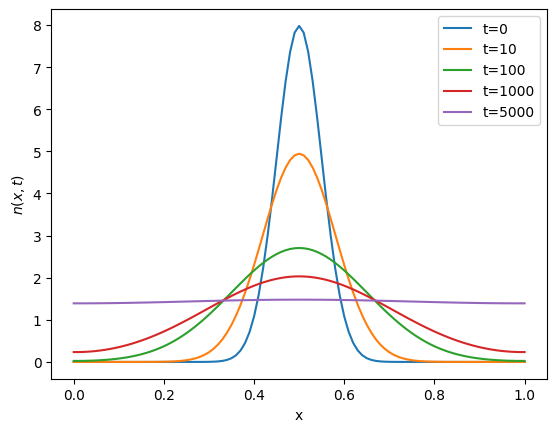

In [6]:
plt.plot(x , pop[:,0], label='t=0')
plt.plot(x, pop[:, 100], label='t=10')
plt.plot(x, pop[:, 500], label='t=100')
plt.plot(x, pop[:, 1000], label='t=1000')
plt.plot(x, pop[:, 5000], label='t=5000')
plt.xlabel('x')
plt.ylabel('$n(x,t)$')
#plt.yscale('log')
plt.legend()
plt.show()

In [8]:
pop_ps = pop[:,:,np.newaxis]
r_ps = r[:,:,np.newaxis]
print(r_ps.shape)

(101, 5001, 1)


In [9]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,
                                          include_bias=False),
    derivative_order=4,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, 
                     alpha=1e-2, 
                     max_iter = 100, 
                     normalize_columns=True,
                     unbias = True
                      )

model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n', 'r'],
                 #differentiation_method=ps.SmoothedFiniteDifference()
                 )
model.fit(pop_ps, t=dt)#u=r_ps, t=dt)
model.print(lhs=['dn/dt'])

STLSQ model: 
dn/dt = 5.001 n + -1.001 n^2 + 1.000 n_11


In [262]:
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=1000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n', 'r', ]
                 )
model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])

SR3 model, L0 norm: 
dn/dt = 5.006 n + -1.009 n^2 + 0.003 n^3 + 1.000 n_11


In [185]:
print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=1000,
    tol=1e-15,
    nu=1e3,
    thresholder="l1",
    normalize_columns=True,
    unbias=True,
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n', 'r', ]
                 )
model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])

SR3 model, L1 norm: 
dn/dt = 0.096 n + -0.114 n^2 + 0.020 n^3 + 0.999 n_11 + 0.001 nn_11


In [10]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=3,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
)

In [18]:
print('Weak form, STLSQ model: ')
optimizer = ps.STLSQ(threshold=.1, 
                     alpha=1e-10,
                     max_iter=50,
                     #normalize_columns=True
                     )


model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['n',]
                      )

model.fit(pop_ps, t=dt)
model.print(lhs=['dn/dt'])


Weak form, STLSQ model: 
dn/dt = 5.000 n + -1.000 n^2 + 1.000 n_11


#### Other optimizers

In [15]:
print('Weak SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.1, 
    max_iter=1000, 
    tol=1e-15, 
    thresholder="l1", 
    #normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n', 'r'])
model.fit(pop_ps, u=r_ps, t=dt)
model.print(lhs=['dn/dt'])

Weak SR3 model, L1 norm: 
dn/dt = 0.000


In [16]:

print('Weak SSR model: ')
optimizer = ps.SSR(kappa=1, 
                   normalize_columns=True, 
)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n', 'r'])
model.fit(pop_ps, u=r_ps, t=dt)
model.print(lhs=['dn/dt'])

Weak SSR model: 
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/Users/saeed/Documents/GitHub/pysindy/.pysindy/lib/python3.10/site-packages/pysindy/optimizers/base.py:181: RuntimeWarning: divide by zero encountered in divide
  reg = 1 / np.linalg.norm(x, 2, axis=0)
/Users/saeed/Documents/GitHub/pysindy/.pysindy/lib/python3.10/site-packages/pysindy/optimizers/base.py:182: RuntimeWarning: invalid value encountered in multiply
  x_normed = x * reg


LinAlgError: SVD did not converge in Linear Least Squares

In [59]:
print('Weak SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   normalize_columns=True, 
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n', 'r'])
model.fit(pop_ps, u=r_ps, t=dt)
model.print(lhs=['dn/dt'])

print('Weak FROLs model: ')
optimizer = ps.FROLS(kappa=1e-3) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, 
                 optimizer=optimizer,
                 feature_names=['n', 'r'])
model.fit(pop_ps, u=r_ps, t=dt)
model.print(lhs=['dn/dt'])

Weak SSR (metric = model residual) model: 
dn/dt = 0.009 r + 0.806 n r + 1.245 n_11 + 0.004 r^2r_1 + -4.389 nn_11 + -1.634 rn_11 + 19.399 n^2n_11 + 16.274 n rn_11
Weak FROLs model: 
dn/dt = 0.000


## Parametric growth + diffusion

In [426]:
# solve diffusion pde

numx = 101
numt = 5001
Lx = 1.0
Tf = 0.1
dx = Lx / (numx-1)
dt = Tf / (numt-1)

x = np.arange(0, Lx + dx, dx)
t = np.arange(0, Tf + dt, dt)

pop = np.zeros((numx, numt))
pop_tst = np.zeros((numx, numt))

r = np.zeros((numx, numt))

mu = 0.5
sigma = 0.05
alpha = 0.7
v = 1.
death_rate = 1.25

pop[:, 0] = np.ones(x.shape[0]) #(x-mu/2)**2 #5*np.ones(x.shape[0]) #np.exp( -(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2) 

pop_tst[:, 0] = np.ones(x.shape[0])

for j in range(t.shape[0]):
    r[:, j] = 6*(x-mu)**2



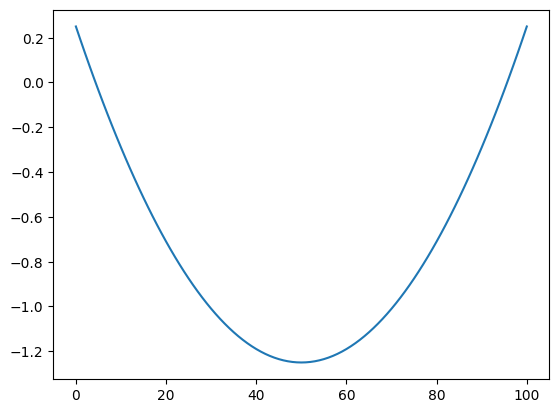

In [267]:
plt.plot(6 * (x-mu)**2 - death_rate)

In [427]:
for j in np.arange(0, numt-1): 
    for i in np.arange(1, numx-1): 
        pop[i,j+1] = pop[i,j] + dt * pop[i,j]*(r[i,j] - death_rate) + (dt/dx**2)*(pop[i+1,j]-2*pop[i,j]+pop[i-1,j])
        pop[i,j+1] = pop[i,j+1] * (pop[i,j+1]>0)
    pop[0, j+1] = pop[1, j+1]    
    pop[numx-1, j+1] = pop[numx-2, j+1]
    


In [428]:
pop_ps = pop[:,:,np.newaxis]
r_ps = r[:,:,np.newaxis]
print(r_ps.shape)

(101, 5001, 1)


In [255]:
plt.clf()

<Figure size 640x480 with 0 Axes>

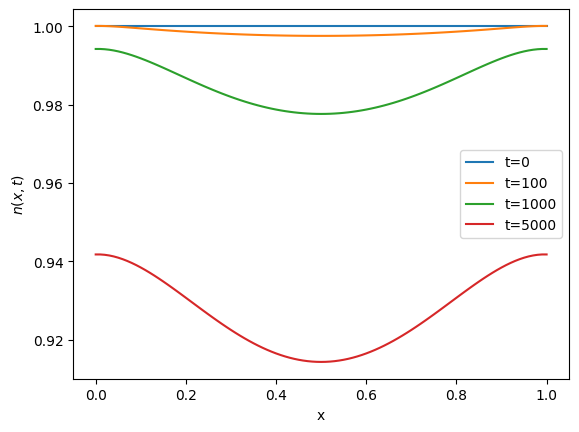

In [429]:
plt.plot(x , pop[:,0], label='t=0')
plt.plot(x, pop[:, 100], label='t=100')
plt.plot(x, pop[:, 1000], label='t=1000')
plt.plot(x, pop[:, 5000], label='t=5000')
plt.xlabel('x')
plt.ylabel('$n(x,t)$')
#plt.yscale('log')
plt.legend()
plt.show()

In [485]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

pde_Wlib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=False,
)

param_Wlib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=0,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
    include_interaction=True,
)

Wlib = ps.ParameterizedLibrary(
    parameter_library=param_Wlib,
    feature_library=pde_Wlib,
    num_parameters=1, #r.shape[0],
    num_features=1,
)



In [432]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=2,
    spatial_grid=x, 
    #temporal_grid=t,
    is_uniform=True,
    include_bias=False,
)

param_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=1,
    spatial_grid=x, 
    #temporal_grid=t, 
    is_uniform=True,
    include_bias=True,
)

lib = ps.ParameterizedLibrary(
    parameter_library=param_lib,
    feature_library=pde_lib,
    num_parameters=1, #r.shape[0],
    num_features=1,
)

In [437]:
print('PDELib, STLSQ model: ')
optimizer = ps.STLSQ(threshold=.3, 
                     alpha=2,
                     max_iter=10000,
                     unbias=True,
                     #normalize_columns=True
                     )


model = ps.SINDy(feature_library=lib, 
                     optimizer=optimizer,
                    #differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['n', 'r']
                      )

model.fit(pop_ps, 
          u=r_ps, 
          t=dt)
model.print(lhs=['dn/dt'])

PDELib, STLSQ model: 
dn/dt = -1.250 1 n + 1.000 1 n_11 + 1.000 r n


In [443]:
print('WeakLib, STLSQ model: ')
optimizer = ps.STLSQ(threshold=.01, 
                     alpha=0,
                     max_iter=10000,
                     unbias=True,
                     normalize_columns=True
                     )


model = ps.SINDy(feature_library=Wlib, 
                     optimizer=optimizer,
                    #differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['n', 'r']
                      )

model.fit(pop_ps, 
          u=r_ps, 
          t=dt)
model.print(lhs=['dn/dt'])

WeakLib, STLSQ model: 
dn/dt = 0.000


# Noisy growth and diffusion

In [454]:
pop_noise = pop +  0.001 * np.random.random(pop.shape)
pop_ps_noise = pop_ps + 0.001 * np.random.random(pop_ps.shape)

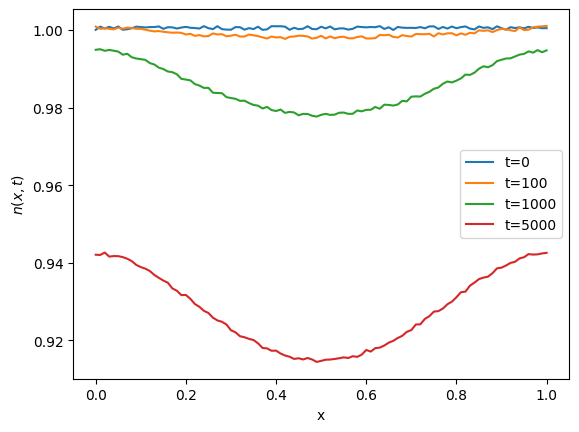

In [455]:
plt.plot(x , pop_noise[:,0], label='t=0')
plt.plot(x, pop_noise[:, 100], label='t=100')
plt.plot(x, pop_noise[:, 1000], label='t=1000')
plt.plot(x, pop_noise[:, 5000], label='t=5000')
plt.xlabel('x')
plt.ylabel('$n(x,t)$')
#plt.yscale('log')
plt.legend()
plt.show()

In [520]:
print('PDELib, STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, 
                     alpha=1,
                     max_iter=10000,
                     unbias=True,
                     normalize_columns=True
                     )


model = ps.SINDy(feature_library=lib, 
                     optimizer=optimizer,
                    #differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['n', 'r']
                      )

model.fit(pop_ps_noise, 
          u=r_ps, 
          t=dt)
model.print(lhs=['dn/dt'])

PDELib, STLSQ model: 
dn/dt = 5.181 1 n + -6.345 1 n^2 + 277.476 1 n_1 + 0.022 1 n_11 + -592.327 1 nn_1 + 316.213 1 n^2n_1 + -0.093 1 nn_11 + 0.071 1 n^2n_11 + -14.580 r n + 16.164 r n^2 + 10.052 r n_1 + -10.997 r nn_1 + -0.050 r nn_11 + 0.061 r n^2n_11 + 2.391 r^2 n + -3.118 r^2 n^2 + -0.578 r^2 n_11 + 1.185 r^2 nn_11 + -0.617 r^2 n^2n_11 + -648.593 r_1 n_1 + 1354.483 r_1 nn_1 + -707.602 r_1 n^2n_1 + -0.445 rr_1 n_1 + 974.394 r^2r_1 n_1 + -2010.587 r^2r_1 nn_1 + 1037.606 r^2r_1 n^2n_1


In [655]:
print('WeakLib, STLSQ model: ')

'''
optimizer = ps.STLSQ(threshold=.1, 
                     alpha=1e-16,
                     max_iter=10000,
                     #unbias=True,
                     #normalize_columns=True
                     ) '''

optimizer =  ps.STLSQ(threshold=1, 
                      alpha=1e-24, 
                      #normalize_columns=True
                      )


model = ps.SINDy(feature_library=Wlib, 
                     optimizer=optimizer,
                    #differentiation_method=ps.SmoothedFiniteDifference(), 
                     feature_names=['n', 'r']
                      )

model.fit(pop_ps_noise, 
          u=r_ps, 
          t=dt)
model.print(lhs=['dn/dt'])

WeakLib, STLSQ model: 
dn/dt = 56.981 1 n_1 + 6.945 1 n_11 + -134.760 1 nn_1 + 80.340 1 n^2n_1 + -68.732 1 nn_11 + 63.445 1 n^2n_11 + -359.397 r n_1 + 697.104 r nn_1 + -340.807 r n^2n_1 + 11.621 r nn_11 + -10.954 r n^2n_11 + -3.060 r^2 n + 2.274 r^2 n^2 + 658.059 r^2 n_1 + -11.479 r^2 n_11 + -1265.374 r^2 nn_1 + 607.046 r^2 n^2n_1 + 87.185 r^2 nn_11 + -78.894 r^2 n^2n_11


In [264]:
eeta_list = np.array([0., 0.01, 0.02, 0.05, 0.1])

pop_noisy = np.array([pop_ps + eta * np.random.random(pop_ps.shape) for eta in eta_list])

pop_noisy_dot = np.array([ps.SmoothedFiniteDifference(axis=1)._differentiat(pop_noisy[i], t=dt) for i in range(pop_noisy.shape[0])])

# Total variation

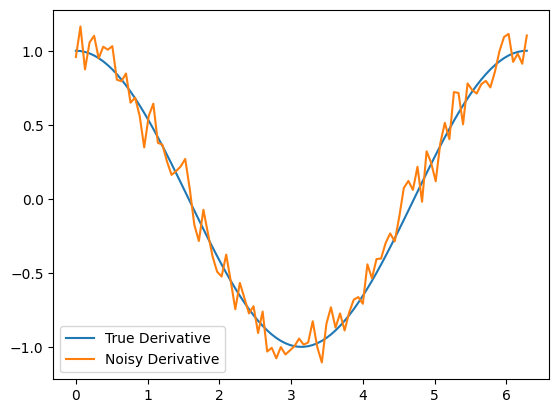

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a simple signal
t = np.linspace(0, 2 * np.pi, 100)
s = np.sin(t)

# Compute its derivative
d = np.cos(t)

# Add noise to the derivative
noise = np.random.normal(0, 0.1, t.shape)
d_noisy = d + noise

plt.plot(t, d, label='True Derivative')
plt.plot(t, d_noisy, label='Noisy Derivative')
plt.legend()
plt.show()